# Importing Data 

In [1]:
import numpy as np
import math
import os
from scipy import signal
from scipy import optimize
import UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

In [2]:
year = 2021
#packets = import_data(f'../{year}/{year}_packet.json')
packets = import_data(f'{year}_packet.json')

# Get Sweep and Saving Figures

In [8]:
def get_sweep(sw, cn = 0):

  sec = np.linspace(0, 1, 5)

  start = sw['Start'] / 1000 # convert milliseconds to seconds
  stop =  sw['Stop'] / 1000

  sw['Voltage'] = np.array(sw['Voltage'])
  sw[f'Current{cn}'] = np.array(sw[f'Current{cn}'])

  V1 = sw['Voltage']     [0: int(sec[1] * len(sw['Voltage' ]))]
  I1 = sw[f'Current{cn}'][0: int(sec[1] * len(sw[f'Current1']))]

  V2 = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[2]*len(sw['Current1'])) ]
  I2 = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[2]*len(sw['Current1'])) ]

  V3 = sw['Voltage']     [int(sec[2]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  I3 = sw[f'Current{cn}'][int(sec[2]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ] 

  V4 = sw['Voltage']     [int(sec[3]*len(sw['Voltage' ]))      :int(sec[4]*len(sw['Current1'])) ]
  I4 = sw[f'Current{cn}'][int(sec[3]*len(sw[f'Current{cn}']))  :int(sec[4]*len(sw['Current1'])) ]

  Vf = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  If = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ]
  return start, stop, V1, I1, V2, I2, V3, I3, V4, I4

# Generate Sweep Images - Every 100

In [20]:
sw_range = np.arange(0,int(len(packets['packets']['Medium'])), 100) 

In [ ]:
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in sw_range:
  for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
  axs[0].set_title(f't = {start} s: {stop}s')
  axs[2].set_xlabel('Voltage')
  axs[1].set_ylabel('Current')
  #plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

# Plot a Single Sweep

The estimated floating potential is 0.615 V.
The estimated plasma potential is 0.8 V.


Text(0, 0.5, 'Current')

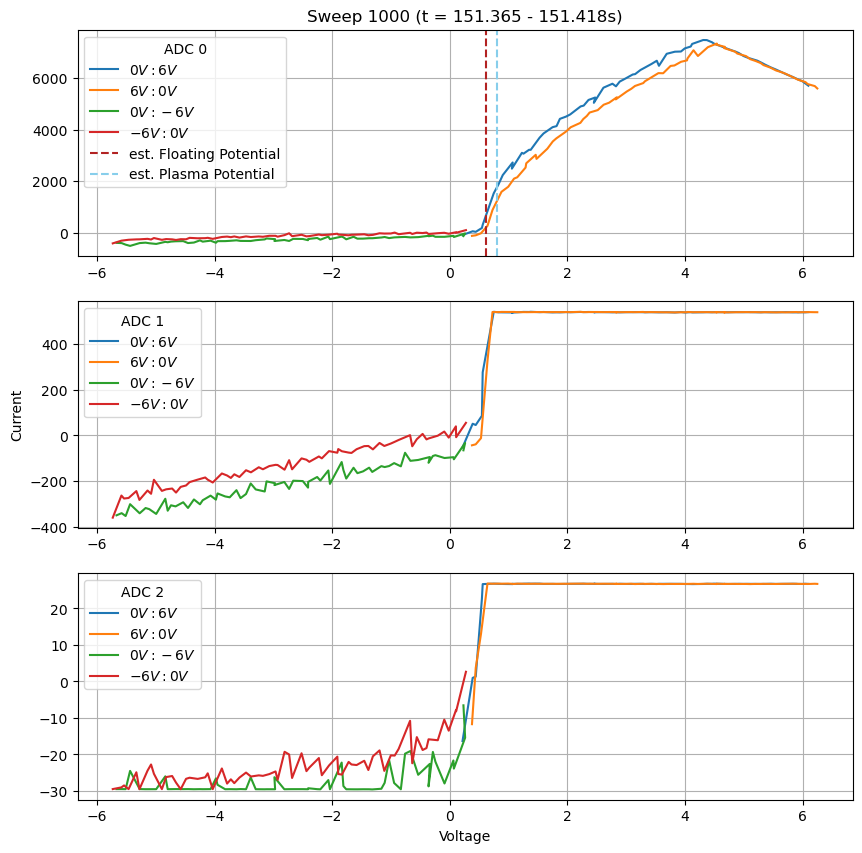

In [18]:
sweepNum = 1000
fp = getFloatingPotential(sweepNum)
plsm = getPlasmaPotential(sweepNum)
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{sweepNum}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
axs[0].axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
axs[0].axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
axs[0].legend(title = f'ADC 0', loc = 'upper left')
axs[0].set_title(f'Sweep {sweepNum} (t = {start} - {stop}s)')
axs[2].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
#plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

# Objectives

Use gen fit 
 * popt = optimize parameters
  t is x, y is model 
extract popt  it will be an array of values array of values
* (Around 30)
Plot it to check to see if you have a good fit 

**Note**: Use Sweeps 1000 - 1900 as they show the best IV curves

* x, y, popt, pcov = genfit(V, I)
    * x and y will be your fitted IV curve
    * popt is an array of m, b ,and a
* look at electron saturation region eq, inside equation is B, get Te from that since everything is a constant besdies Te
* Look at line 44 in rock sat fitting functions 

Use log linear fit for voltage instead of normal linear fit

_Q_: What are the units for the output?
* T is in Kelvin
* n is in m^3

# Fitting Functions

In [44]:
def jarrod_fit(sweepNum):
    V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
    I = packets['packets']['Medium'][f'{sweepNum}']['Current0']
    x_raw, y_raw = np.array(V), np.array(I)
    x,y = data_processing(x_raw,y_raw)
    # x,y = R_fitting.data_processing(x_raw,y_raw)
    # g = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    #change 10000 to something lower for temperature bounds
    b = ((-3, -3, -np.inf, -np.inf, 0, 0, -3, -3), (3, 3, np.inf, np.inf, np.inf, 10000, 3, 3))  # bounds
    popt, pcov = optimize.curve_fit(model, x, y, p0=[0.6,0.8,-14,80, 5*(10**10),1000,-0.5,-0.5], bounds=b)
    
    t = np.linspace(min(x), max(x), num=264)
    return t, model(t,*popt),popt,pcov #popt[0:fp,1:plsm,2:offset,3:ionSlope,4:n,5:temp,6:V0,7:Vp]

def printIVAnalysis(sweepNum):
    x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I
    fp, plsm, offset, ionSlope, n, temp, V0, Vp = popt
    print(f'popt = {popt}')
    print('')
    print(f'The floating potential is {round(fp, 3)} V.')
    print(f'The plasma potential is {round(plsm, 3)} V.')
    print(f'The current offset is {round(offset, 3)} nA.')
    print(f'The ion saturation slope is {round(ionSlope, 3)}.')
    print(f'The electron density is {round(n, 3)} cm^(-3).')
    print(f'The electron temperature is {round(temp, 3)} K.')
    print(f'The voltage offset is {round(V0, 3)} V.')
    print('')

In [62]:
def model(x, xf, xp, b, m1, n, t, V0, Vp):
    # changed to be hopefully more efficient
    ret = np.zeros(len(x))
    for i in range(0, len(x)):
        if(x[i] <= xf):
            ret[i] = seg1(x[i], m1) - seg1(xf, m1) + b
        # Something wrong with this part, messes up the fit ##################################################
        elif(xf < x[i] <= xp):
            ret[i] = seg2(x[i], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
        ######################################################################################################
        elif(x[i] > xp):
            ret[i] = seg3(x[i], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
        
    # ret[x <= xf] = seg1(x[x <= xf], m1) - seg1(xf, m1) + b
    # ret[x > xp] = seg3(x[x > xp], n, t, V0) - seg3(xp, n, t, V0) + seg1(xp, m1) - seg1(xp, m1) + b
    # ret[xf < x <= xp] = seg2(x[xf < x <= xp], n, t, Vp) - seg2(xf, n, t, Vp) + seg1(xf, m1) - seg1(xf, m1) + b
    return ret

In [56]:
def seg1(x, m):  # linear--ion saturation
    return m * x

def seg2(x,n,t,Vp):  # exponential -- electron transition region
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I_therm = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I_therm * math.exp(k * (x - Vp))

def seg3(x, n, t, V0):  # square root
    q_e = 1.602 * 10 ** -19  # C                charge of an electron
    K_b = 1.381 * 10 ** -23  # m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10 ** -31  # kg               mass of an electron
    R = (3. / 16.) * 0.0254  # radius of probe
    L = (3.25) * 0.0254  # length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2)  # area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 = n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10 ** -9)
    return I0 * np.sqrt(1. + k * (x + V0))

In [46]:
def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    max_ind = np.argmax(y_raw) #find index of maximum y
    if (max_ind.size != 1):
        min_max_val = np.argmin(x_raw[max_ind]) #find minimum x of max y
    else:
        min_max_val = max_ind
    ind_high = np.where(x_raw > x_raw[min_max_val] + 0.1) # find indexs of x greater than 0.1 more than max y
    ind_low = np.where(x_raw < 0) #find indexs of x less than 0
    ind_rem = np.concatenate((ind_high,ind_low),axis=None)
    x = np.delete(x_raw,ind_rem) #remove from x
    y = np.delete(y_raw,ind_rem) #remove from y
    return x,y

In [47]:
def getFloatingPotential(sweepNum):
    x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I
    print(f'The estimated floating potential is {round(popt[0], 3)} V.')
    return popt[0]

def getPlasmaPotential(sweepNum):
    x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I
    print(f'The estimated plasma potential is {round(popt[1], 3)} V.')
    return popt[1]

# Fitting a Single Sweep

In [48]:
sweepNum = 1000  # Use Sweep 1000 to 1800 

In [63]:
# x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I)) # x is V, y is I
x, y, popt, pcov = jarrod_fit(sweepNum) # x is V, y is I

printIVAnalysis(sweepNum)

popt = [ 6.14680629e-01  8.00000000e-01 -1.40000000e+01  8.00000000e+01
  5.00000000e+10  1.00025306e+03 -5.00000000e-01 -4.19993392e-01]

The floating potential is 0.615 V.
The plasma potential is 0.8 V.
The current offset is -14.0 nA.
The ion saturation slope is 80.0.
The electron density is 49999999999.998 cm^(-3).
The electron temperature is 1000.253 K.
The voltage offset is -0.5 V.



The estimated floating potential is 0.615 V.
The estimated plasma potential is 0.8 V.


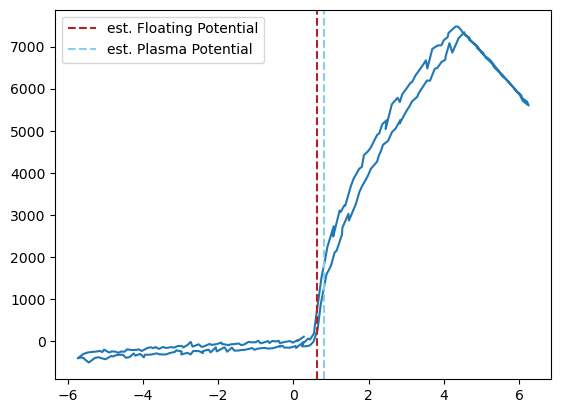

In [66]:
V = packets['packets']['Medium'][f'{sweepNum}']['Voltage']
I = packets['packets']['Medium'][f'{sweepNum}']['Current0']

plt.plot(V,I)
#plt.plot(x,y)
fp = getFloatingPotential(sweepNum)
plsm = getPlasmaPotential(sweepNum)
plt.axvline(x = fp, linestyle = '--', color = 'firebrick', label = 'est. Floating Potential')
plt.axvline(x = plsm, linestyle = '--', color = 'skyblue', label = 'est. Plasma Potential')
plt.legend()
# Limit to 1 V 